# EXERCISE 2

#### Introduction
In this exercise we train a deep convolutional neural network to classify hand-written digits on the MNIST dataset. After the network develops a respectable test-accuracy we built and train another network that generates handwritten images based on 5 samples from the dataset. This generator learns to create images that to the human eye are identical to these 5 samples, but produces them with different labels in order to "confuse" our classifier leading him to missclasify them.<br>
Our strategy is the following: <br>
We built a composite model that consists of the generator followed by our trained cnn classifier. The generator is then trained as part of this composite model in which the cnn classifier's parameters remain unchanged. The idea is that the generator must learn to produce images relative to the cnn classifier's performance on those generated images. On every epoch, the generator's weights change with respect to the error  computed at the output of the cnn classifier, given the generated images. In this way the generator can learn to produce more realistic images.

#### Libraries

In [66]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.datasets import mnist
from keras import models as m
from keras import layers as l
from keras import regularizers as r
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

#### Prepare and visualize MNIST data

Train labels:  {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
Test labels:  {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


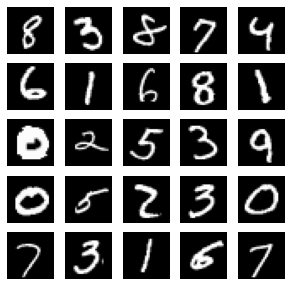

In [2]:
l# load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# count the number of unique train labels
unique, counts = np.unique(y_train, return_counts=True)
print("Train labels: ", dict(zip(unique, counts)))

# count the number of unique test labels
unique, counts = np.unique(y_test, return_counts=True)
print("Test labels: ", dict(zip(unique, counts)))

y_train = to_categorical(y_train,10)
y_test = to_categorical(y_test,10)

# sample 25 mnist digits from train dataset
indexes = np.random.randint(0, x_train.shape[0], size=25)
images = x_train[indexes]
labels = y_train[indexes]

# plot the 25 mnist digits
plt.figure(figsize=(5,5))
for i in range(len(indexes)):
    plt.subplot(5, 5, i + 1)
    image = images[i]
    plt.imshow(image, cmap='gray')
    plt.axis('off')

plt.show()
plt.close('all')

#### Prediction Function 

In [3]:
def predict(x, predictor):
    # Get the data from the test set
    # Get output of network and prediction
    activations = predictor.predict(x.reshape(1, 28, 28, 1))
    prediction = np.argmax(activations)
    # Print the prediction of the network
    print('Network output: ')
    print(activations)
    print('Network prediction: ')
    print(prediction)
    print('Actual image: ')
    # Draw the image
    plt.bar(range(10), activations[0])
    plt.show()
    plt.imshow(x.reshape((28,28)), cmap='Greys')
    plt.show()

#### Built cnn model

In [6]:
cnn = m.Sequential()

cnn.add(l.Conv2D(32, (3,3), strides = 1, padding = 'same', input_shape = (28,28,1)))
cnn.add(l.LeakyReLU(alpha=0.2))
cnn.add(l.MaxPooling2D(pool_size = (2,2), strides = 2))

cnn.add(l.Conv2D(64, (3,3), strides = 1, padding = 'same'))
cnn.add(l.LeakyReLU(alpha=0.2))
cnn.add(l.MaxPooling2D(pool_size = (2,2), strides = 2))

cnn.add(l.Flatten())

cnn.add(l.Dense(64, activation = 'relu'))
        
cnn.add(l.Dense(10, activation='softmax'))

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                    

#### Built and train the cnn classifier

In [15]:
cnn.compile(loss='categorical_crossentropy',
                     optimizer = tf.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5),
                     metrics = ['accuracy']
                     )
history = cnn.fit(x_train, y_train, epochs = 5, shuffle = True,
                    validation_split = 0.33)

Epoch 1/5
1257/1257 [==============================] - 21s 17ms/step - loss: 0.0343 - accuracy: 0.9896 - val_loss: 0.0547 - val_accuracy: 0.9835
Epoch 2/5
1257/1257 [==============================] - 21s 17ms/step - loss: 0.0287 - accuracy: 0.9910 - val_loss: 0.0506 - val_accuracy: 0.9861
Epoch 3/5
1257/1257 [==============================] - 20s 16ms/step - loss: 0.0236 - accuracy: 0.9927 - val_loss: 0.0504 - val_accuracy: 0.9856
Epoch 4/5
1257/1257 [==============================] - 21s 17ms/step - loss: 0.0199 - accuracy: 0.9935 - val_loss: 0.0603 - val_accuracy: 0.9825
Epoch 5/5
1257/1257 [==============================] - 20s 16ms/step - loss: 0.0162 - accuracy: 0.9949 - val_loss: 0.0549 - val_accuracy: 0.9845


#### Evaluate test score of cnn classifier

In [16]:
 cnn.evaluate(x_test, y_test, batch_size = 128)

79/79 [==============================] - 1s 14ms/step - loss: 0.0360 - accuracy: 0.9889


[0.03600514680147171, 0.9889000058174133]

#### Build the generator network
This network receives one input equal to 1 and expands it through 4 hidden layers (1 dense, 2 convolutional, 1 dense), in order to produce a 28x28 pixel image. When the generator is untrained it produces images with no meaning, but when it is trained as part of the composite model, it produces images based on samples from the dataset.<br><br>
> Note: this network is basically the middle part of an autoencoder. Given images with lower resolution (compressed), it's purpose is to reconstruct them keeping only the important features.

In [30]:
Input = l.Input(shape=(1,))
# 256 parallel low resolution (7x7) representations of the output image
hidden = l.Dense(256*7*7, activation = l.LeakyReLU(alpha = 0.2))(Input)
hidden = l.BatchNormalization()(hidden)
hidden = l.Reshape((7,7,256))(hidden)
#upsample to 14x14 
hidden = l.Conv2DTranspose(512, (4,4), strides = (2,2), padding = 'same', activation = l.LeakyReLU(alpha = 0.2))(hidden)
hidden = l.BatchNormalization()(hidden)
#upsample to 28x28 
hidden = l.Conv2DTranspose(1024, (4,4), strides = (2,2), padding = 'same', activation = l.LeakyReLU(alpha = 0.2))(hidden)
hidden = l.BatchNormalization()(hidden)
hidden = l.Dense(1, activation = 'sigmoid')(hidden)
Output = l.Reshape((28, 28, 1))(hidden)
#Output = l.Conv2D(1, (7,7), padding = 'same', activation = 'sigmoid')(hidden)
Generator = m.Model(Input,Output)

Generator.summary()
Generator.compile(
    loss = 'mean_squared_error',
    optimizer = tf.optimizers.Adam(learning_rate = 0.001),
    metrics = [tf.keras.metrics.RootMeanSquaredError()]
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_2 (Dense)             (None, 12544)             25088     
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 512)      2097664   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 512)      2048  

#### Build the Generative Adversarial Examples composite model 

In [34]:
cnn.trainable = False

composite = m.Sequential()
composite.add(Generator)
composite.add(cnn)
composite.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 28, 28, 1)         10569729  
                                                                 
 sequential (Sequential)     (None, 10)                220234    
                                                                 
Total params: 10,789,963
Trainable params: 10,541,569
Non-trainable params: 248,394
_________________________________________________________________


#### Compile the composite model

In [35]:
composite.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.optimizers.Adam(learning_rate = 0.001),
    metrics = ["accuracy"])


#### Choose 5 digits as samples for the training of the Generator

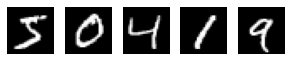

In [36]:
digits = np.array([0,1,2,3,4,5,6,7,8,9])
samples = x_train[0:5]
plt.figure(figsize=(5,5))
for i in range(len(samples)):
    plt.subplot(5, 5, i + 1)
    image = samples[i]
    plt.imshow(image, cmap='gray')
    plt.axis('off')

plt.show()
plt.close('all')

#### Train the Generator through the composite model
We save the generator's produced images on a list to plot them later. The training consists of the following strategy:<br>
> For every sample we use as targets all 9 other digits. Then for every target and 100 epochs we first train the generator on the sample and then we train him again through the composite model feeding it wrong target labels. In this way the generator updates it's weights according to the performance of the the cnn. When the cnn's performance is good (low error) the generator updates more, when the cnn's performance is low (big error) the generator updates less.  

In [38]:
generatorImages = []

for sample in samples:
    for target in digits:
        if target != np.argmax(cnn.predict(sample.reshape(1,28,28,1))):
            classArr = np.zeros((1,10))
            classArr[0][target] = 1
            print(classArr)
            for _ in tqdm(range(100)):
                Generator.train_on_batch([np.array([1])], sample.reshape(1,28,28,1))
                composite.train_on_batch([np.array([1])], classArr)
            generatorImage = Generator.predict([np.array([1])]).reshape(1, 28, 28, 1)
            generatorImages.append(generatorImage)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  5.00it/s]


[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.16it/s]


[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.94it/s]


[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.97it/s]


[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.99it/s]


[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.89it/s]


[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.32it/s]


[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.22it/s]


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.35it/s]


[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.64it/s]


[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.46it/s]


[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.46it/s]


[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.45it/s]


[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.54it/s]


[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.58it/s]


[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.47it/s]


[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.93it/s]


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.87it/s]


[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.95it/s]


[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.48it/s]


[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.84it/s]


[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.89it/s]


[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.88it/s]


[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.98it/s]


[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.91it/s]


[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.85it/s]


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.93it/s]


[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.93it/s]


[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.79it/s]


[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.70it/s]


[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.77it/s]


[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.19it/s]


[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.87it/s]


[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.00it/s]


[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.86it/s]


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.88it/s]


[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.89it/s]


[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.93it/s]


[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.51it/s]


[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.89it/s]


[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.95it/s]


[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.99it/s]


[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.93it/s]


[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.93it/s]


[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.86it/s]


#### Plot The Generated Images and the cnn classifier predictions on them

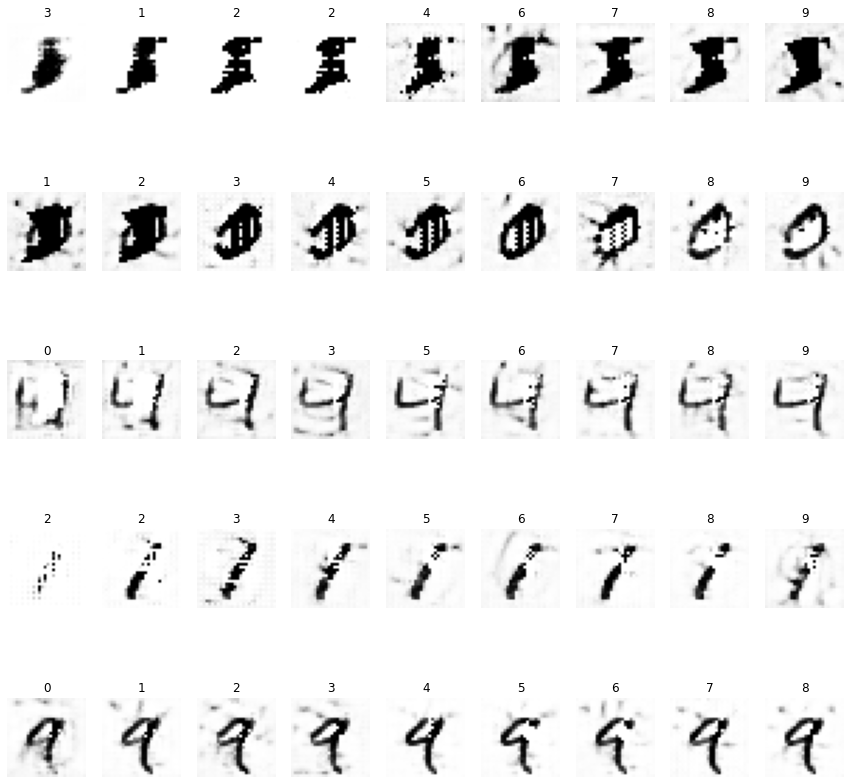

In [85]:
plt.figure(figsize=(15,15))
for i in range(len(generatorImages)):
    plt.subplot(len(samples), len(digits)-1, i + 1)
    plt.axis('off')
    plt.imshow(generatorImages[i].reshape((28,28)), cmap='gray_r')
    plt.title(np.argmax(cnn.predict(generatorImages[i])))
    
filename = 'generatorImages.png'
plt.savefig(filename)
plt.show()
plt.close('all')

The above images are not perfect replicas of the samples, but still the nines, zeros and ones are pretty good and we clearly see that the cnn missclassifies them.

#### Build a classifier that is robust to the generated images
My approach is to build a deeper cnn model and add some regularization and dropout in it's layers in order to increase it's generalization ability. In this way i believe that it will become imune to adversarial attacks.

#### Buid deeper regularized cnn model

In [57]:
deep_cnn = m.Sequential()

deep_cnn.add(l.Conv2D(32, (3,3), strides = 1, padding = 'same', 
                input_shape = (28,28,1), kernel_regularizer=r.l1(0.00001)))
deep_cnn.add(l.LeakyReLU(alpha=0.2))
deep_cnn.add(l.MaxPooling2D(pool_size = (2,2), strides = 2))

deep_cnn.add(l.Conv2D(64, (3,3), strides = 1, padding = 'same', 
                input_shape = (28,28,1), kernel_regularizer=r.l1(0.00001), bias_regularizer = r.l2(0.0001)))
deep_cnn.add(l.LeakyReLU(alpha=0.2))
deep_cnn.add(l.MaxPooling2D(pool_size = (2,2), strides = 2))
deep_cnn.add(l.Dropout(0.3))

deep_cnn.add(l.Conv2D(128, (3,3), strides = 1, padding = 'same', 
                input_shape = (28,28,1), kernel_regularizer=r.l1(0.00001)))
deep_cnn.add(l.BatchNormalization())
deep_cnn.add(l.LeakyReLU(alpha=0.2))
deep_cnn.add(l.MaxPooling2D(pool_size = (2,2), strides = 2))
deep_cnn.add(l.Dropout(0.35))

deep_cnn.add(l.Conv2D(256, (3,3), strides = 1, padding = 'same', 
                input_shape = (28,28,1), kernel_regularizer=r.l1(0.00001), bias_regularizer = r.l2(0.0001)))
deep_cnn.add(l.BatchNormalization())
deep_cnn.add(l.LeakyReLU(alpha=0.2))
deep_cnn.add(l.MaxPooling2D(pool_size = (2,2), strides = 2))
deep_cnn.add(l.Dropout(0.35))

deep_cnn.add(l.Flatten())

deep_cnn.add(l.Dense(1024, activation = l.LeakyReLU(alpha=0.2), kernel_regularizer = r.l1(0.00001), bias_regularizer = r.l2(0.0001)))
deep_cnn.add(l.BatchNormalization())

deep_cnn.add(l.Dense(512, activation = l.LeakyReLU(alpha=0.2), kernel_regularizer = r.l1(0.00001), bias_regularizer = r.l2(0.0001)))
deep_cnn.add(l.BatchNormalization())

deep_cnn.add(l.Dense(256, activation = l.LeakyReLU(alpha=0.2)))
deep_cnn.add(l.BatchNormalization())

deep_cnn.add(l.Dense(64, activation = l.LeakyReLU(alpha=0.2)))
deep_cnn.add(l.BatchNormalization())
        
deep_cnn.add(l.Dense(10, activation='softmax'))

deep_cnn.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                

#### Compile  the deep cnn model

In [81]:
deep_cnn.compile(
                loss='categorical_crossentropy',
                optimizer=tf.optimizers.Adam(),
                metrics=['accuracy'])


#### Train the deep_cnn model

In [82]:
deep_cnn.fit(x_train, y_train, epochs = 5, shuffle = True, batch_size = 32,
                    validation_split = 0.33)

Epoch 1/5
1257/1257 [==============================] - 57s 44ms/step - loss: 1.2754 - accuracy: 0.9087 - val_loss: 0.7325 - val_accuracy: 0.9822
Epoch 2/5
1257/1257 [==============================] - 59s 47ms/step - loss: 0.6601 - accuracy: 0.9641 - val_loss: 0.4840 - val_accuracy: 0.9878
Epoch 3/5
1257/1257 [==============================] - 53s 42ms/step - loss: 0.4931 - accuracy: 0.9695 - val_loss: 0.3934 - val_accuracy: 0.9870
Epoch 4/5
1257/1257 [==============================] - 50s 40ms/step - loss: 0.4145 - accuracy: 0.9739 - val_loss: 0.3544 - val_accuracy: 0.9848
Epoch 5/5
1257/1257 [==============================] - 65s 52ms/step - loss: 0.3656 - accuracy: 0.9765 - val_loss: 0.3024 - val_accuracy: 0.9901


#### Plot the generated images again with the deep_cnn model's predictions on them

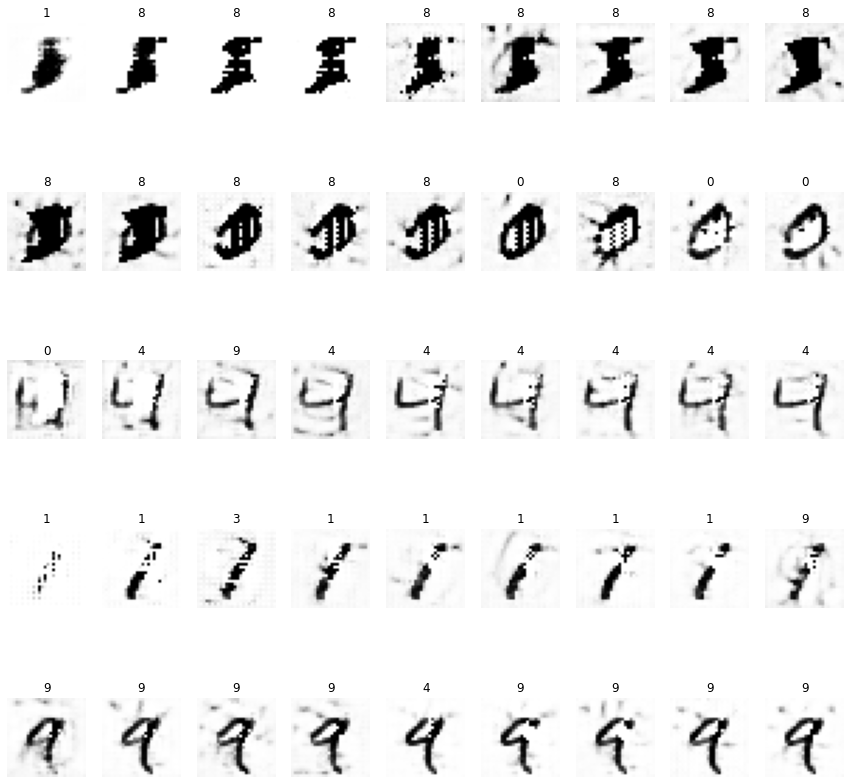

In [83]:
plt.figure(figsize=(15,15))
for i in range(len(generatorImages)):
    plt.subplot(len(samples), len(digits)-1, i + 1)
    plt.axis('off')
    plt.imshow(generatorImages[i].reshape((28,28)), cmap='gray_r')
    plt.title(np.argmax(deep_cnn.predict(generatorImages[i])))
    
filename = 'generatorImages.png'
plt.savefig(filename)
plt.show()
plt.close('all')

> Note: The new cnn classifier performs poorly on the fives and zeros but manages to classify correctly most of the fours, and almost all ones and nines.  